In [55]:
import numpy as np
import thermo_funcs_two as tf
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize, fsolve, least_squares
from numpy.polynomial import Polynomial

In [56]:
def noise(transf,E_mids,occupf_L, occupf_R, coeff, type = "thermal"):
    plusF = occupf_L(E_mids)*(1-occupf_R(E_mids)) + occupf_R(E_mids)*(1-occupf_L(E_mids))
    occupdiff = occupf_L(E_mids) - occupf_R(E_mids)
    term_one = coeff(E_mids)**2 *(transf *plusF)
    term_two = - coeff(E_mids)**2 * transf**2*occupdiff**2
    if type == "full":
        integrands =  term_one + term_two
    elif type == "classic":
        integrands = term_one
    elif type == "quantum":
        integrands = term_two
    elif type == "thermal":
        integrands = coeff(E_mids)**2*transf*(occupf_L(E_mids)*(1-occupf_L(E_mids)) + occupf_R(E_mids)*(1-occupf_R(E_mids)))

    return np.sum(integrands)

def noise_cont(E_low,E_high,occupf_L, occupf_R, coeff, transf):
    thermal = lambda E: coeff(E)**2*transf(E)*(occupf_L(E)*(1-occupf_L(E))+ occupf_R(E)*(1-occupf_R(E)))
    shot = lambda E: coeff(E)**2 * transf(E)*(1-transf(E))*(occupf_L(E)+occupf_R(E))**2
    integrand = lambda E: thermal(E) + shot(E)
    current, err = integrate.quad(integrand, E_low, E_high, args=())
    return current

def maybe_transf(E_mids, occupf_L, occupf_R, coeff, target):
    plusF = occupf_L(E_mids)*(1-occupf_R(E_mids)) + occupf_R(E_mids)*(1-occupf_L(E_mids))
    occupdiff = occupf_L(E_mids) - occupf_R(E_mids)
    unknown_transf = lambda lamda: plusF/(2*occupdiff**2) - lamda/(2*coeff(E_mids)*occupdiff)
    func = lambda lamda: tf.slice_current_integral(unknown_transf(lamda), E_mids,occupf_L, occupf_R, coeff) - target
    res = fsolve(func, 1)
    transf = unknown_transf(res[0])
    print(res[0])
    return transf



def noise_maximize_eff(transf, E_mids,occupf_L, occupf_R, coeff_in, coeff_out, type = "full"):
    input = noise(transf, E_mids,occupf_L, occupf_R, coeff_in, type)
    output = tf.slice_current_integral(transf, E_mids,occupf_L, occupf_R, coeff_out)
    eff = output/input
    return -eff

def minimize_noise_avg(transf, E_mids,occupf_L, occupf_R, coeff_in, coeff_out, type = "thermal"):
    nois = noise(transf, E_mids,occupf_L, occupf_R, coeff_out, type)
    avg = tf.slice_current_integral(transf, E_mids,occupf_L, occupf_R, coeff_in)
    #print(nois)
    #print(avg)

    #nois = noise(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)
    #input_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_in)
    #print(nois*avg)
    return nois*avg

def positive_current(transf, E_mids,occupf_L, occupf_R, coeff):
    avg = tf.slice_current_integral(transf, E_mids,occupf_L, occupf_R, coeff)
    return avg

def noise_constraint(transf, E_mids,occupf_L, occupf_R, coeff, target):
    current = tf.slice_current_integral(transf, E_mids,occupf_L, occupf_R, coeff)
    return target-current
def def_pert(E, muL, TL, muR, TR):
    E0 = tf.E_max(muL,TL,muR,TR)
    #pert = 0.5*fermi_dist(E, muL+0.1, TL + 0.1)  - 0.5*fermi_dist(E,muL,TL)
    #ratio = ((-1-E0)/(5-E0)).as_integer_ratio()
    pert = 0.1*np.sin((E - E0)*8*np.pi/(5-E0))*np.exp(-0.5*np.abs(E-E0))
    #print(type(E))
    if type(E) == np.ndarray:
        pert[E > 5] = 0
        pert[E < -1] = 0
    else:
        if E > 5:
            pert = 0
        if E < -1:
            pert = 0
    #pert = np.ones_like(E)*0.2
    #pert[E<0.2] = 0
    #pert[E>1] = 0 
    #pert[pert > 1] = 1
    #pert[pert < 0] = 0
    return pert

In [57]:
'''
T = 1
    deltaT = 0.5
    TL = T+deltaT
    TR = T-deltaT
    muR = 0
    init_muL = -1
    deltamu = init_muL-muR
    N = 1
    tf.N = N
    target_power = 0.6*tf.pmax(TL,TR)
    small_E_range = np.linspace(-1,5,100)
'''
Es = np.linspace(-1,2,200)
deltaT = 0.5
muL = -0.5
TR = 1-deltaT
TL = 1+deltaT
muR = 0

#occupf_L = lambda E: tf.pertub_dist(E, lambda E: tf.fermi_dist(E, muL, TL), def_pert(E, muL, TL, muR, TR))
#occupf_L = lambda E: 0.2*np.sin(4*E)+0.5
occupf_L = lambda E: tf.fermi_dist(E, muL, TL)
occupf_R = lambda E: tf.fermi_dist(E,muR, TR)

coeff_in = lambda E: -(muR-muL)
#coeff_in = lambda E: TL*tf.entropy_coeff(Es, occupf_L)
#coeff_in = lambda E: tf.entropy_coeff(E)
#coeff_in = lambda E: -(E-muL)/TL + (E-muR)/TR
#coeff_in = lambda E: -tf.entropy_coeff(E, occupf_L) + (E-muR)/TR
coeff_out = lambda E: -E+muR
#coeff_out = lambda E: TL*tf.entropy_coeff(E, occupf_L) - E + muR
#coeff_out = lambda E: E-muL
#coeff_out = lambda E: E-muL

#target = 0.5*tf.pmax(TL,TR)
target = 0.5*tf.jRmax(occupf_L, occupf_R, muR)
print(target)

init_transf = np.random.uniform(0,1,len(Es))
res = minimize(noise_maximize_eff, init_transf, args = (Es,occupf_L, occupf_R, coeff_out, coeff_out, "full"), bounds=(((0,1),)*len(Es)),
        constraints = [{'type':'eq', 'fun': tf.slice_pow_constraint, 'args':(Es,occupf_L, occupf_R, coeff_out, target)}])
transf_noise = res.x

res = minimize(minimize_noise_avg, init_transf, args = (Es,occupf_L, occupf_R, coeff_in, coeff_out, "thermal"), bounds=(((0,1),)*len(Es)),
        constraints = [{'type':'eq', 'fun': tf.slice_pow_constraint, 'args':(Es,occupf_L, occupf_R, coeff_out, target)}])
                        #{'type':'ineq', 'fun': tf.slice_current_integral, 'args':(Es,occupf_L, occupf_R, coeff_in)}])
transf_noise_avg = res.x
print(res.message)

res = minimize(tf.slice_maximize_eff, init_transf, args = (Es,occupf_L, occupf_R, coeff_in, coeff_out), bounds=(((0,1),)*len(Es)),
        constraints = [{'type':'eq', 'fun': tf.slice_pow_constraint, 'args':(Es,occupf_L, occupf_R, coeff_out, target)}])
transf_gen = res.x




0.0004213762359625647
Optimization terminated successfully


In [58]:
C_init = 0.3
C_avg = tf.general_opt_avg(C_init, target, Es[0], Es[-1],occupf_L, occupf_R, coeff_in, coeff_out)
#print(C_avg)
transf_C_avg = lambda E: tf.transmission_avg(C_avg, E, occupf_L, occupf_R, coeff_in, coeff_out)

C_noise = tf.general_opt_noise(C_init, target, Es[0], Es[-1], occupf_L, occupf_R, coeff_out)
transf_C_noise = lambda E: tf.transmission_noise(C_noise, E, occupf_L, occupf_R, coeff_out)


print(target)
print(C_avg)
print(C_noise)


nois_opt = tf.noise_cont(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_C_noise)
curr_cor_nois_opt = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_in, transf_C_noise)

nois_for_curr_opt = tf.noise_cont(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_C_avg)
curr_opt = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_in, transf_C_avg)

if nois_opt*curr_cor_nois_opt < curr_opt*nois_for_curr_opt:
    max_prod = nois_opt*curr_cor_nois_opt
else:
    max_prod = curr_opt*nois_for_curr_opt
print(max_prod)

0.0004213762359625647
0.3
0.676228975819496
0.0


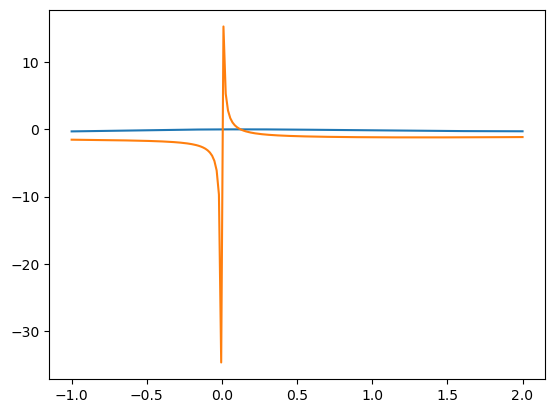

In [59]:
comp = (occupf_L(Es) - occupf_R(Es))/(coeff_out(Es)*(occupf_L(Es) *(1-occupf_L(Es)) + occupf_R(Es)*(1-occupf_R(Es))))
plt.plot(Es, coeff_out(Es)*(occupf_L(Es)- occupf_R(Es)))
plt.plot(Es, comp-C_noise)
#plt.plot(Es, coeff_out(Es))
plt.show()


In [60]:
def calc_transf(thetas,occupf_L, occupf_R, coeff_avg, coeff_nois, coeff_con, max_prod, return_opt_func = False):
    div = lambda E: coeff_con(E)*(occupf_L(E)-occupf_R(E))
    term_one = lambda E: -thetas[0]*coeff_nois(E)**2*(occupf_L(E)*(1-occupf_L(E))+occupf_R(E)*(1-occupf_R(E)))#/div(E)
    term_two = lambda E: -thetas[1]*coeff_avg(E)*(occupf_L(E)-occupf_R(E))#/div(E)
    
    term_three = lambda E: thetas[2]*div(E)
    #opt_func = lambda E: x(E)**2*(fL(E)*(1-fL(E))) #+ fR(E)*(1-fR(E))) + thetas[1]*y(E)*(fL(E)-fR(E)) - thetas[2]*x(E)*(fL(E)-fR(E))
    opt_func = lambda E: term_one(E)+term_two(E)+term_three(E)
    #print(-thetas[0]*thetas[1] + max_prod)
    transf_avg_nois = lambda E: np.heaviside(opt_func(E), 0)#*np.heaviside(coeff_avg(E)*(occupf_L(E)-occupf_R(E)),0)*np.heaviside(coeff_con(E)*(occupf_L(E)-occupf_R(E)),0)#*np.heaviside(-thetas[0]*thetas[1] + max_prod,0)
    if return_opt_func:
        return transf_avg_nois, opt_func
    return transf_avg_nois
    
def opt_noise_avg(thetas, E_low, E_high, occupf_L, occupf_R, coeff_avg, coeff_nois, coeff_con, target, max_prod):

    transf_avg_nois = calc_transf(thetas,occupf_L, occupf_R, coeff_avg, coeff_nois, coeff_con, max_prod)
    nois = noise_cont(E_low, E_high, occupf_L, occupf_R, coeff_nois, transf_avg_nois)
    avg = tf.current_integral(E_low, E_high, occupf_L, occupf_R, coeff_avg, transf_avg_nois)
    con = tf.current_integral(E_low, E_high, occupf_L, occupf_R, coeff_con, transf_avg_nois)
    print(con)
    #nois = noise(transf_avg_nois, Es, occupf_L, occupf_R, coeff_nois)
    #avg = tf.slice_current_integral(transf_avg_nois, Es, occupf_L, occupf_R, coeff_avg)
    #con = tf.slice_current_integral(transf_avg_nois, Es, occupf_L, occupf_R, coeff_nois)
    #print(nois,avg,con)
    return avg - thetas[0], nois - thetas[1], con-target

0.000837768101716641
0.000837768101716641
0.000837768101716641
0.000837768101716641
0.000837768101716641
0.000837768101716641
0.0008224363868224221
0.0008223841190415606
0.0008207815912643185
0.00080610980129134
0.0008160820494842481
0.00079525446214441
0.0007789539392381339
0.0006600834488558443
0.0007582223323359214
0.0007789539392381339
0.0007789539392381339
0.0007789539392381339
0.0007625768547986218
0.0007747448547859993
0.0007654993892114286
0.0007514932475522461
0.0006731446147280759
0.0007306072984460511
0.0007514932475522461
0.0007514932475522461
0.0007514932475522461
0.0007329010824291273
0.0007452696557510404
0.0007326950109337624
0.0006989788776746009
0.000541102643275026
0.0006719730254821771
0.0006989788776746009
0.0006989788776746009
0.0006989788776746009
0.0006683199970908586
0.0006955812888294161
0.0006955774824593738
0.0006836574438365401
0.0006627199370474178
0.0005646725859210393
0.0006400635859098728
0.0006627199370474178
0.0006627199370474178
0.0006627199370474178

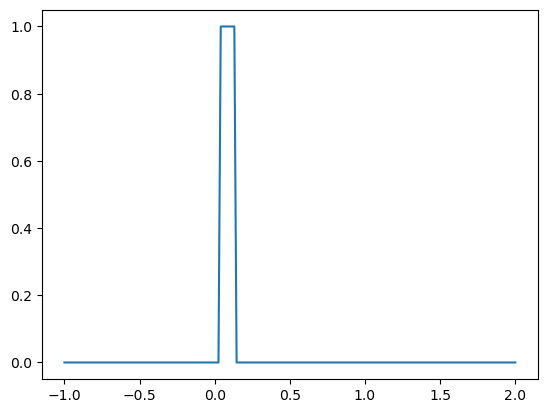

In [61]:
#input_opt = tf.slice_current_integral(transf_C_avg, Es,occupf_L, occupf_R, coeff_in)
#nois_opt = noise(transf_C_noise, Es,occupf_L, occupf_R, coeff_out)
#opt_func = lambda C: input_opt * coeff_out(Es)**2 * (occupf_L(Es)*(1-occupf_L(Es))) + nois_opt*coeff_in(Es)*(occupf_L(Es)- occupf_R(Es)) - C*coeff_out(Es)*(occupf_L(Es) - occupf_R(Es))
#transf_avg_nois_func = lambda C: np.heaviside(opt_func(C), 0)
#output_target_func = lambda C: tf.slice_current_integral(transf_avg_nois_func(C), Es,occupf_L, occupf_R, coeff_out) -target
#Es = np.linspace(-1,5,100)
max_transf = lambda E: np.heaviside(coeff_out(E)*(occupf_L(E) - occupf_R(E)),0)
max_input = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_in, max_transf)
max_noise = tf.noise_cont(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, max_transf)
thetas_init = [max_input/2, max_noise/2, 0.1]
res = fsolve(opt_noise_avg, thetas_init, factor = 0.1, args = (Es[0],Es[-1], occupf_L, occupf_R, coeff_in, coeff_out, coeff_out, target, max_prod), full_output=True, epsfcn=None)
print(res)
thetas = res[0]
print(opt_noise_avg(thetas,Es[0], Es[-1],occupf_L, occupf_R, coeff_in, coeff_out, coeff_out, target, max_prod))
transf_avg_nois, opt_func = calc_transf(thetas,occupf_L, occupf_R, coeff_in, coeff_out, coeff_out, max_prod, return_opt_func=True)
#transf_noise_avg = transf_avg_nois_func(C_avg_nois)
plt.plot(Es, transf_avg_nois(Es))

In [62]:

transf_opt = lambda C,E: np.heaviside(coeff_out(E)**2*(occupf_L(E)*(1-occupf_L(E))+occupf_R(E)*(1-occupf_R(E)))*coeff_in(E)*(occupf_L(E)-occupf_R(E)) - C,0)*np.heaviside(coeff_out(E)*(occupf_L(E)-occupf_R(E)),0)*np.heaviside(coeff_in(E)*(occupf_L(E)-occupf_R(E)),0)
fixed_current_eq = lambda C: tf.current_integral(Es[0], Es[-1],occupf_L, occupf_R,coeff_out,lambda E:transf_opt(C,E)) - target
res = fsolve(fixed_current_eq,0.0005, factor=0.1)
print(res[0])
print(target)
#transf_avg_nois = lambda E: transf_opt(res[0],E)



0.0005
0.0004213762359625647


C:\Users\elsad\AppData\Local\Temp\ipykernel_33452\72529096.py:3: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  res = fsolve(fixed_current_eq,0.0005, factor=0.1)


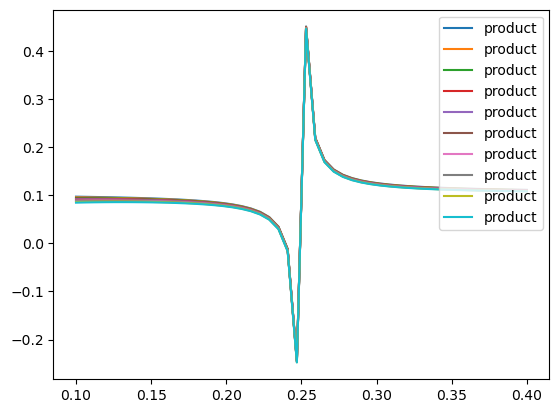

In [63]:
Es_plot = np.linspace(0.1,0.4)

#prod_slice = coeff_out(Es_plot)**2*(occupf_L(Es_plot)*(1-occupf_L(Es_plot))+occupf_R(Es_plot)*(1-occupf_R(Es_plot)))*coeff_in(Es_plot)*(occupf_L(Es_plot)-occupf_R(Es_plot))
inputs = np.linspace(0,max_input,10)
for input in inputs:
    prod_slice = (coeff_out(Es_plot)**2*(occupf_L(Es_plot)*(1-occupf_L(Es_plot))+occupf_R(Es_plot)*(1-occupf_R(Es_plot)))*input + coeff_in(Es_plot)*(occupf_L(Es_plot)-occupf_R(Es_plot))*max_noise)/(coeff_out(Es_plot)*(occupf_L(Es_plot)-occupf_R(Es_plot)))
    #plt.plot(Es_plot, coeff_out(Es_plot)*(occupf_L(Es_plot)-occupf_R(Es_plot)), label = "I_out" )
    #plt.plot(Es_plot, coeff_in(Es_plot)*(occupf_L(Es_plot)-occupf_R(Es_plot)), label = "I_in")

    #plt.plot(Es_plot, prod_slice, label = "product")
noises = np.linspace(0,max_noise,10)

for nois_i in noises:
    prod_slice = -(coeff_out(Es_plot)**2*(occupf_L(Es_plot)*(1-occupf_L(Es_plot))+occupf_R(Es_plot)*(1-occupf_R(Es_plot)))*inputs[5] + coeff_in(Es_plot)*(occupf_L(Es_plot)-occupf_R(Es_plot))*nois_i)/(coeff_out(Es_plot)*(occupf_L(Es_plot)-occupf_R(Es_plot)))+0.1
    #plt.plot(Es_plot, coeff_out(Es_plot)*(occupf_L(Es_plot)-occupf_R(Es_plot)), label = "I_out" )
    #plt.plot(Es_plot, coeff_in(Es_plot)*(occupf_L(Es_plot)-occupf_R(Es_plot)), label = "I_in")

    plt.plot(Es_plot, prod_slice, label = "product")

#plt.xlim(0,0.5)
#plt.ylim(-0.1,0.05)
plt.legend()
plt.show()

[0.00264087 0.00038039 0.00596876]
1.0045535810968442e-06
-1.0045535810968442e-06
0.0008044774663179498
(0.0038663470325139776, 0.00210472299543917, 0.0003831012303553851)
0.0
(-1.1111111111111112, -0.0003803868884993397, -0.0004213762359625647)
0.0
(-2.2222222222222223, -0.0003803868884993397, -0.0004213762359625647)
0.0
(-3.3333333333333335, -0.0003803868884993397, -0.0004213762359625647)
0.0
(-4.444444444444445, -0.0003803868884993397, -0.0004213762359625647)
0.0
(-5.555555555555555, -0.0003803868884993397, -0.0004213762359625647)
0.0
(-6.666666666666667, -0.0003803868884993397, -0.0004213762359625647)
0.0
(-7.777777777777779, -0.0003803868884993397, -0.0004213762359625647)
0.0
(-8.88888888888889, -0.0003803868884993397, -0.0004213762359625647)
0.0
(-10.0, -0.0003803868884993397, -0.0004213762359625647)


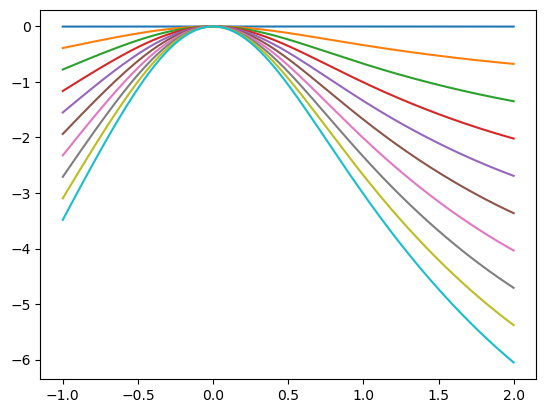

In [64]:
print(thetas)
print(thetas[0]*thetas[1])
print(-thetas[0]*thetas[1]+max_prod)
lamdas = np.linspace(0,10,10)
noises = np.linspace(0,0.1,10)
test_thetas = np.copy(thetas)

for lamda in lamdas:
    test_thetas[0] = lamda    
    #test_thetas[1] = lamda
    #test_thetas[2] = lamda
    print(opt_noise_avg(test_thetas,Es[0], Es[-1],occupf_L, occupf_R, coeff_in, coeff_out, coeff_out, target, max_prod))
    ransfnsfnsf, opt_func = calc_transf(test_thetas,occupf_L, occupf_R, coeff_in, coeff_out, coeff_out, max_prod, return_opt_func = True)
    plt.plot(Es, opt_func(Es))
#plt.plot(Es, coeff_out(Es)*(occupf_L(Es)-occupf_R(Es)))
#plt.plot(Es, coeff_in(Es)*(occupf_L(Es)-occupf_R(Es)))
#plt.xlim([1,5])
#plt.ylim([0,2])

plt.show()

In [65]:
'''
#Need a real integral....
cs = np.linspace(-6,-8,1000)
diffs = []
for c in cs:
    opt_func = 0.27203328419852246*x**2*(fL*(1-fL) + fR*(1-fR)) + 3.929815050207161*y*(fL-fR) - c*x*(fL-fR)
    transf_avg_nois = np.heaviside(opt_func, 0)
    con = tf.slice_current_integral(transf_avg_nois, Es, occupf_L, occupf_R, coeff_out)
    diffs.append(con-target)
plt.plot(cs, diffs)
pltshow()'
'''

"\n#Need a real integral....\ncs = np.linspace(-6,-8,1000)\ndiffs = []\nfor c in cs:\n    opt_func = 0.27203328419852246*x**2*(fL*(1-fL) + fR*(1-fR)) + 3.929815050207161*y*(fL-fR) - c*x*(fL-fR)\n    transf_avg_nois = np.heaviside(opt_func, 0)\n    con = tf.slice_current_integral(transf_avg_nois, Es, occupf_L, occupf_R, coeff_out)\n    diffs.append(con-target)\nplt.plot(cs, diffs)\npltshow()'\n"

In [66]:
#transf_noise_avg = np.heaviside(occupf_L(Es)-occupf_R(Es),0)
nois = noise(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)
input_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_in)
output_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)

print("Input current noise avg: ", input_current)
print("Output current noise avg: ", output_current)
print("Noise noise avg: ", nois)
print("Efficiency noise avg: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")

nois = noise_cont(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_C_noise)
input_current = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_in, transf_C_noise)
output_current = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_C_noise)

print("Input current C noise: ", input_current)
print("Output current C noise: ", output_current)
print("Noise noise C: ", nois)
print("Efficiency noise C: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")

nois = noise_cont(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_C_avg)
input_current = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_in, transf_C_avg)
output_current = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_C_avg)

print("Input current C avg: ", input_current)
print("Output current C avg: ", output_current)
print("Noise C avg: ", nois)
print("Efficiency C avg: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")

#transf_avg_nois = calc_transf(thetas,occupf_L, occupf_R, coeff_in, coeff_out, coeff_out, max_prod)
#transf_avg_nois = lambda E:np.heaviside(E-0.1235,0)*np.heaviside(0.2988-E,0)
#transf_avg_nois = lambda E: 0.8 * np.exp(-(E-0.12)**2/0.1**2)
#transf_avg_nois = lambda E: (-25*(E-0.12)**2 + 0.85)*np.heaviside(-25*(E-0.12)**2 + 0.85, 0)*np.heaviside(coeff_out(E)*(occupf_L(E) - occupf_R(E)),0)
nois = noise_cont(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_avg_nois)
input_current = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_in, transf_avg_nois)
output_current = tf.current_integral(Es[0], Es[-1], occupf_L, occupf_R, coeff_out, transf_avg_nois)

print("Input current noise avg calc: ", input_current)
print("Output current noise avg calc: ", output_current)
print("Noise noise avg calc: ", nois)
print("Efficiency noise avg calc: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")

print("S*I limit: ", curr_opt*nois_opt)

'''

nois = noise(transf_gen, Es,occupf_L, occupf_R, coeff_out)
input_current = tf.slice_current_integral(transf_gen, Es,occupf_L, occupf_R, coeff_in)
output_current = tf.slice_current_integral(transf_gen, Es,occupf_L, occupf_R, coeff_out)

print("Input current gen: ", input_current)
print("Output current gen: ", output_current)
print("Noise gen: ", nois)
print("Efficiency gen: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")
nois = noise(transf_noise, Es,occupf_L, occupf_R, coeff_out)
input_current = tf.slice_current_integral(transf_noise, Es,occupf_L, occupf_R, coeff_in)
output_current = tf.slice_current_integral(transf_noise, Es,occupf_L, occupf_R, coeff_out)

print("Input current noise: ", input_current)
print("Output current noise: ", output_current)
print("Noise noise: ", nois)
print("Efficiency noise: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")
'''


#plt.plot(Es,transf_gen, label = "Transf gen")
#plt.plot(Es, transf_noise, label = "Transf noise")
plt.plot(Es, transf_noise_avg,'--' ,label = "Transf noise avg", zorder = 3)
plt.plot(Es, transf_avg_nois(Es),'--' ,label = "Transf noise avg calc", zorder = 3)

plt.plot(Es, transf_C_noise(Es) ,label = "Transf C noise", zorder = 2)
plt.plot(Es, transf_C_avg(Es) ,label = "Transf C avg", zorder = 1)
#plt.plot(Es, tf.transmission_avg_avg(0.3, Es, occupf_L, occupf_R, coeff_in, coeff_out), label = "transf test")
#plt.plot(Es, transf_calc, label = "Transf calc")
plt.plot(Es, np.heaviside(coeff_out(Es)*(occupf_L(Es) - occupf_R(Es)),0), label = "Max JR")
plt.plot(Es, occupf_L(Es), label = "Occup L")
plt.plot(Es, occupf_R(Es), label = "Occup R")
plt.legend()
#plt.ylim([0,1])
plt.show()

Input current noise avg:  0.004297147504160846
Output current noise avg:  0.0004212784293291219
Noise noise avg:  0.20852434938876516
Efficiency noise avg:  0.09803676250843286
input * noise 0.0008960598875326965


Input current C noise:  0.003826069287051425
Output current C noise:  0.0004213740729657097
Noise noise C:  0.0003115808544165916
Efficiency noise C:  0.11013236858824459
input * noise 1.1921299375165625e-06


Input current C avg:  0.0
Output current C avg:  0.0
Noise C avg:  0.0


ZeroDivisionError: float division by zero